# URL Classification

+ https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
+ https://towardsdatascience.com/naive-bayes-classifier-from-scratch-with-python-942708211470
+ https://scikit-learn.org/stable/modules/naive_bayes.html
+ https://github.com/japborst/dart_stemmer/blob/master/lib/PorterStemmer.dart
+ https://tartarus.org/martin/PorterStemmer/
+ https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls
+ https://www.kaggle.com/datasets/akashkr/phishing-website-dataset
+ https://www.kaggle.com/datasets/sandunabeysooriya/phishing-detection-dataset
+ https://www.youtube.com/watch?v=O2L2Uv9pdDA
+ https://www.kaggle.com/code/tylersullivan/classifying-phishing-urls-three-models
+ https://towardsdatascience.com/how-i-was-using-naive-bayes-incorrectly-till-now-part-1-4ed2a7e2212b
+ https://towardsdatascience.com/why-how-to-use-the-naive-bayes-algorithms-in-a-regulated-industry-with-sklearn-python-code-dbd8304ab2cf
+ https://towardsdatascience.com/all-you-need-to-know-about-bag-of-words-and-word2vec-text-feature-extraction-e386d9ed84aa
+ https://towardsdatascience.com/text-normalization-7ecc8e084e31
+ https://medium.com/analytics-vidhya/how-to-build-a-lemmatizer-7aeff7a1208c

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

import matplotlib.pyplot as plt
%matplotlib inline

## Data Import and Cleaning

__Features of interest:__
+ Length
+ Number of dots
+ Number of sub-paths `/`
+ Usage of shortening services
+ Usage of symbols, such as `@`, `?`, `//`
+ Using `http` or `https`
+ Domain (`.gov`, `.com`, etc.)
+ Is IP address

In [2]:
data = pd.read_csv("./data/phishing_site_urls.csv", encoding="utf-8")
data["Label"].replace(to_replace="bad", value=1, inplace=True)
data["Label"].replace(to_replace="good", value=0, inplace=True)

print(data)
# print(data.info())

                                                      URL  Label
0       nobell.it/70ffb52d079109dca5664cce6f317373782/...      1
1       www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...      1
2       serviciosbys.com/paypal.cgi.bin.get-into.herf....      1
3       mail.printakid.com/www.online.americanexpress....      1
4       thewhiskeydregs.com/wp-content/themes/widescre...      1
...                                                   ...    ...
549243                                    23.227.196.215/      1
549244                                 apple-checker.org/      1
549245                                  apple-iclods.org/      1
549246                                 apple-uptoday.org/      1
549247                                  apple-search.info      1

[549248 rows x 2 columns]


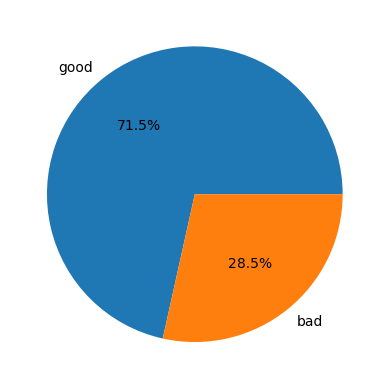

In [3]:
sizes = [data[data["Label"] == 0].shape[0]
        ,data[data["Label"] == 1].shape[0]
        ]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=["good", "bad"], autopct='%1.1f%%')
plt.show()

In [42]:
import re
from collections import Counter

ip_re = re.compile(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}(:\d{1,5})?$")
hexa_re = re.compile(r"^[0-9a-f]+$")
split_re = re.compile(r"\W|[_\-]")

#----------------------------#

vowels = {'a','e','i','o','u','y'}

# assumes lowercase and w.isalpha() is True
def readable(w: str) -> bool:
    tl, nb = 0, 0
    i, cs  = 0, 1
    while i < len(w):
        cs = 1
        v  = w[i] in vowels
        i += 1
        while i < len(w) and (w[i] in vowels) == v:
            cs += 1
            i  += 1
        if cs > 2:
           nb += 1
        tl += 1
    return (nb / tl) < 0.2

#----------------------------#
    
# Remove parsing artifacts (won't be needed for the real thing)
def cleanURL(url: str) -> str:
    s, e = 0, len(url)
    qs = ["'", '"']
    if url[0] in qs:
        s = 1
    if url[-1] in qs:
        e -= 1
    if url[e-1] == '/':
        e -= 1
    return url[s:e]

#----------------------------#

def getPathStart(url: str) -> tuple:
    i = 0
    while i < len(url) and url[i] != '/': i+=1
    return i

#----------------------------#

def categorize(w: str) -> str:
    if w.isdigit():
        return 'NUM'
    if not w.isalpha():
        return 'OTHER'
    if len(w) < 4:
        return 'SMALL'
    if not readable(w):
        return 'JUNK'
    if len(w) > 15:
        return 'LONG'
    else:
        return 'WORD'

#----------------------------#

# Extract properties and features from URL
def processURL(url: str) -> list:
    curl = cleanURL(url)
    ps = getPathStart(curl)
    ts = Counter([categorize(t.lower()) for t in split_re.split(curl) if len(t) > 0])
    return [ curl.count('%')
           , curl.count('.')
           , curl.count('/')
           , curl.count('//')
           , curl.count(':')
           , curl.count('?')
           , curl.count('@')
           , int(ip_re.search(curl[:ps]) != None)
           , ps
           , len(curl)-ps
           , ts['JUNK']
           , ts['LONG']
           , ts['NUM']
           , ts['OTHER']
           , ts['SMALL']
           , ts['WORD']
           ]

#==========================================#

cs = ['%','.','/','//',':','?','@','ip','lenA','lenP','JUNK','LONG','NUM','OTHER','SMALL','WORD']
vs = pd.DataFrame(data["URL"].map(processURL).to_list(), columns=cs)

print(vs)

        %  .   /  //  :  ?  @  ip  lenA  lenP  JUNK  LONG  NUM  OTHER  SMALL  \
0       0  6  10   0  0  1  0   0     9   216     1     0    4      2     12   
1       0  5   4   0  0  0  0   0    15    66     2     0    1      0      7   
2       0  7  10   0  0  0  0   0    16   160     0     0    0      2      4   
3       0  6   2   0  0  0  0   0    18    42     1     0    0      0      3   
4       0  1   9   1  0  1  0   0    19    96     0     0    1      1      2   
...    .. ..  ..  .. .. .. ..  ..   ...   ...   ...   ...  ...    ...    ...   
549243  0  3   0   0  0  0  0   1    14     0     0     0    4      0      0   
549244  0  1   0   0  0  0  0   0    17     0     1     0    0      0      1   
549245  0  1   0   0  0  0  0   0    16     0     1     0    0      0      1   
549246  0  1   0   0  0  0  0   0    17     0     1     0    0      0      1   
549247  0  1   0   0  0  0  0   0    17     0     2     0    0      0      0   

        WORD  
0         13  
1        

In [53]:
expl = "www.henkdeinumboomkwekerij.nl/language/pdf_fonts/smiles.php"

print([categorize(t.lower()) for t in split_re.split(expl) if len(t) > 0])
print(processURL(expl))

['SMALL', 'LONG', 'SMALL', 'WORD', 'SMALL', 'JUNK', 'WORD', 'SMALL']
[0, 3, 3, 0, 0, 0, 0, 0, 29, 30, 1, 1, 0, 0, 4, 2]


## Training and Testing



In [44]:
trainX, testX, trainY, testY = train_test_split(vs, data.Label, test_size=0.3, random_state=0)

In [45]:
mnb = MultinomialNB()
mnb.fit(trainX, trainY)

pred = mnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.77      0.93      0.84    118073
         bad       0.63      0.32      0.42     46702

    accuracy                           0.75    164775
   macro avg       0.70      0.62      0.63    164775
weighted avg       0.73      0.75      0.72    164775



In [46]:
cnb = ComplementNB()
cnb.fit(trainX, trainY)

pred = cnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.81      0.82      0.81    118073
         bad       0.52      0.51      0.51     46702

    accuracy                           0.73    164775
   macro avg       0.66      0.66      0.66    164775
weighted avg       0.73      0.73      0.73    164775



In [55]:
dt = DecisionTreeClassifier(random_state=0, max_depth=len(cs))
dt.fit(trainX, trainY)

pred = dt.predict(testX)
print(dt.tree_.node_count)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

12665
              precision    recall  f1-score   support

        good       0.90      0.95      0.92    118073
         bad       0.84      0.72      0.78     46702

    accuracy                           0.88    164775
   macro avg       0.87      0.83      0.85    164775
weighted avg       0.88      0.88      0.88    164775



In [48]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, max_iter=5, tol=None)
svm.fit(trainX, trainY)

pred = svm.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.76      0.99      0.86    118073
         bad       0.84      0.19      0.32     46702

    accuracy                           0.76    164775
   macro avg       0.80      0.59      0.59    164775
weighted avg       0.78      0.76      0.70    164775



---
## Post-Processing

+ Node Pruning
+ Function Pruning
+ Code generation

In [49]:
# Prune redundant branches
# https://stackoverflow.com/a/68660641

from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        inner_tree.feature[index] = TREE_UNDEFINED
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)
    
prune_duplicate_leaves(dt)

# Test to make sure we didn't create problems
pred = dt.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.90      0.95      0.92    118073
         bad       0.84      0.72      0.78     46702

    accuracy                           0.88    164775
   macro avg       0.87      0.83      0.85    164775
weighted avg       0.88      0.88      0.88    164775



In [50]:
# Optimize Node Path, removing duplicate nodes

ctf = {} # node that parent one true and one false leaf
cft = {} # node that parent one false and one true leaf (the order matters)

fts = dt.tree_.feature
trh = np.floor(dt.tree_.threshold).astype(int)
left  = dt.tree_.children_left
right = dt.tree_.children_right
val = dt.tree_.value

# Find all node with two leaf as children
for i in range(0, dt.tree_.node_count):
    lf = bool(val[left[i]][0].argmax()) if left[left[i]] == right[left[i]] else None
    rh = bool(val[right[i]][0].argmax()) if left[right[i]] == right[right[i]] else None
    if lf == None or rh == None:
        continue
    # Parent of two leaf
    elif lf and not rh:
        k = (fts[i], trh[i])
        if ctf.get(k) != None:
            ctf[k].append(i)
        else:
            ctf[k] = [i]
    elif not lf and rh:
        k = (fts[i], trh[i])
        if cft.get(k) != None:
            cft[k].append(i)
        else:
            cft[k] = [i]


ng = [x for x in ctf.items() if len(x[1]) > 1]
ng.extend([x for x in cft.items() if len(x[1]) > 1])

# Create a normal map between old node to the new node
nc = 0
normals = {}
for _, xs in ng:
    nv = xs[0]
    nc += len(xs)-1
    for i in xs[1:]:
        normals[i] = nv

print(nc) # number of deleted functions
print(ng) # all function duplicate groups

1284
[((8, 10), [17, 1788, 2065, 2489, 2969, 3140, 3153, 5516, 6266, 6900, 7214, 8762]), ((1, 0), [41, 158, 1569, 6348]), ((15, 2), [52, 4400, 4519, 4587, 4753, 6151, 7937, 8140, 9822, 9958, 11016, 11629]), ((9, 7), [66, 361, 6637, 6788, 6985]), ((9, 10), [72, 7225, 7271, 7279, 7283, 7346, 7570, 7704]), ((8, 23), [95, 923, 1346, 1438, 1713, 1854, 2349, 2820, 5455, 7141, 10213]), ((8, 29), [106, 646]), ((8, 16), [115, 595, 616, 1534, 3851, 5818, 5877, 7543, 9117]), ((8, 24), [150, 1449, 2918, 4135, 4748, 5408, 5840, 6625, 7297, 9790, 11195]), ((8, 12), [190, 3118, 4021, 7701, 11265, 11386, 11974]), ((10, 1), [228, 1250, 1894, 2636, 4212, 5502, 6860, 7838, 7985, 8936, 9218, 9232, 9530, 10444, 10549, 10792, 10800, 11407, 11410, 11486, 11622, 12447]), ((1, 1), [269, 964, 1400, 1411, 2191, 2195, 3689, 3809, 5689, 5706, 5724, 7628, 9985, 10047, 10167, 10299, 10608]), ((15, 3), [297, 777, 2319, 2858, 3056, 3484, 3512, 4481, 8250, 8806, 10642, 10761, 10929, 11067, 11128, 11760]), ((8, 19), [33

In [52]:
# Generate Flutter code
fs = ""

fts = dt.tree_.feature
trh = np.floor(dt.tree_.threshold).astype(int)
left  = dt.tree_.children_left
right = dt.tree_.children_right
val = dt.tree_.value

nf = 0

for i in range(0, dt.tree_.node_count):
    if normals.get(i) != None:
        continue
    elif left[i] != right[i]:
        lnv = normals[left[i]] if normals.get(left[i]) != None else left[i]
        rnv = normals[right[i]] if normals.get(right[i]) != None else right[i]
        lf = str(bool(val[lnv][0].argmax())).lower() if left[lnv] == right[lnv] else '_check{0}'.format(lnv)
        rh = str(bool(val[rnv][0].argmax())).lower() if left[rnv] == right[rnv] else '_check{0}'.format(rnv)
        nf += 1
        if lf == 'true' and rh == 'false':
            fs += '  bool get _check{0} => _vector[{1}] <= {2};\n'.format(i, fts[i], trh[i])
        elif lf == 'false' and rh == 'true':
            # fs += '  bool get _check{0} => !(_vector[{1}] <= {2});\n'.format(i, fts[i], trh[i])
            fs += '  bool get _check{0} => _vector[{1}] > {2};\n'.format(i, fts[i], trh[i])
        else:
            fs += '  bool get _check{0} => (_vector[{1}] <= {2}) ? {3} : {4};\n'.format(i, fts[i], trh[i], lf, rh)

print(nf) # number of functions generated
            
# Generate code
with open("../lib/ai/url_decision_tree.dart", "w") as f:
    f.writelines([
        "import 'package:spam_chat/ai/transformer.dart';\n\n",
        '//=================================================//\n\n',
        '/// A Decision Tree encoded as a class with each nodes being a function. Used for URL classification.\n',
        '///\n',
        '/// (Code generated by python script `model/url.ipynb`)\n',
        'class UrlDecisionTree {\n',
            '  UrlDecisionTree(this.transformer);\n\n',
            '  final Transformer<int, String> transformer;\n\n',
            '  static const featureCount = {0};\n\n'.format(len(cs)),
            '  List<int> _vector = [];\n\n'
            '  //----------------------------//\n\n',
            '  bool predict(String url) {\n',
                '    _vector = transformer.transform(url);\n',
                '    assert(_vector.length == featureCount);\n',
                '    return _check0;\n',
            '  }\n\n',
            '  //----------------------------//\n\n',
            fs, # nodes
        '}',
    ])

3865
